In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import torch
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

# Загрузка и обработка данных

Отсортируем данные по возрастанию ts

In [118]:
dataframe = pd.read_csv('ratings.csv')
dataframe.sort_values('ts', inplace = True)
dataframe.reset_index(drop=True, inplace = True)
dataframe.rename(columns = {'user_uid':'user_id', 'element_uid':'item_id'}, inplace = True)

Воспользуемся LabelEncoder для юзеров и айтемов

In [119]:
u_enc = LabelEncoder()
i_enc = LabelEncoder()
dataframe['user_id'] = u_enc.fit_transform(dataframe['user_id'])
dataframe['item_id'] = i_enc.fit_transform(dataframe['item_id'])

In [107]:
dataframe.head()

,user_id,item_id,rating,ts
0,65882,6586,2,4.173065e+07
1,86840,5912,7,4.173078e+07
2,62263,2443,8,4.173079e+07
3,5710,4521,8,4.173085e+07
4,30028,1110,8,4.173086e+07


Напишем класс для хранения данных

In [5]:
class RatingsDataset(Dataset):
    
    def __init__(self, X, y=None):

        self.users = X.user_id
        self.items = X.item_id
        self.ratings = y
        
    def __len__(self,):

        return len(self.users)

    def __getitem__(self, i):
        
        return self.users[i], self.items[i], self.ratings[i]
    
    @staticmethod
    def collate(batch):
        
        users = torch.tensor([elem[0] for elem in batch])
        items = torch.tensor([elem[1] for elem in batch])
        ratings = torch.tensor([elem[2] for elem in batch])    
        
        return users, items, ratings

# Построение модели

In [6]:
class Block(nn.Module):
    def __init__(self, input_size, output_size, activation = "relu", dropout = True, p = 0.5):
        super().__init__()
        
        self.linear = nn.Linear(input_size, output_size)
        if activation == "relu":
            self.activation = nn.ReLU()
        elif activation == "elu":
            self.activation = nn.ELU()
        elif activation == "swish":
            self.activation = nn.SiLU()
        else:
            nn.Identity()
        self.dropout = nn.Dropout(p) if dropout else nn.Identity()

    def forward(self, x):
        y1 = self.linear(x)
        y2 = self.activation(y1)
        y3 = self.dropout(y2)
        return y3

In [7]:
class NeuralCF(nn.Module):
    def __init__(self, n_users, n_items, n_factors,  hidden_layers_sizes, activations, dropouts, minmax):
        super().__init__()
        
        self.n_factors = n_factors
        self.n_users = n_users
        self.n_items = n_items
        self.min_rating, self.max_rating = minmax
        
        self.u_emb = nn.Embedding(self.n_users, self.n_factors)
        self.i_emb = nn.Embedding(self.n_items, self.n_factors)
    
        # реализуем первый блок, входная признаковая размерность равна n_factors*2,
        # так как мы сначала конкатенируем полученные эмбеддинги для юзеров и айтемов
        layers = [Block(2*n_factors, hidden_layers_sizes[0], activation = activations[0], dropout = dropouts[0])]
        
        for i in range(len(hidden_layers_sizes)-1):
            layers.append(Block(hidden_layers_sizes[i], hidden_layers_sizes[i+1], activation = activations[i+1], dropout = dropouts[i+1]))
            
        layers.append(nn.Linear(hidden_layers_sizes[-1], 1))
        
        
        layers.append(nn.Sigmoid())
        
        self.net = nn.Sequential(*layers)
                

    def forward(self, users, items): 
        
        # получим признаки с помощью генерации эмбеддингов для юзеров и айтемов
        features = torch.cat([self.u_emb(users), self.i_emb(items)], dim=1)
        
        out = self.net(features)
        
        #преобразуем полученные рейтинги из [0,1] в [min_rating, max_rating]
        
        return (self.max_rating - self.min_rating) * out + self.min_rating     

In [8]:
n_users = len(np.unique(dataframe.user_id))
n_items = len(np.unique(dataframe.item_id))

# Обучение модели

In [9]:
def RMSELoss(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred)**2))

In [10]:
def run_epoch(stage, model, dataloader, loss_fn, optimizer, epoch, device):
    
    if stage == "train":
        model.train()
        torch.set_grad_enabled(True)
    else:
        torch.set_grad_enabled(False)
        model.eval()

    model = model.to(device)
    
    losses = []
    for batch in tqdm(dataloader, total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}"):
        us, its, ys_true = batch
                
        ys_pred = model(us.to(device), its.to(device))
        loss = loss_fn(ys_pred, ys_true.to(device))

        if stage == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
                
        losses.append(loss.detach().cpu().item())

    return np.mean(losses)

Будем контролировать значение целевой метрики на тестовой выборке и сохранять чекпоинт модели в случае, если он лучший

In [11]:
def save_checkpoint(model, filename):

    with open(filename, "wb") as fp:
        torch.save(model.state_dict(), fp)

def load_checkpoint(model, filename):

    with open(filename, "rb") as fp:
        state_dict = torch.load(fp, map_location="cpu")
    
    model.load_state_dict(state_dict)

In [12]:
def run_experiment(model, dataloader_train, dataloader_val, loss_fn, optimizer, num_epochs, device, output_dir):
    
    train_losses = []
    val_losses = []

    best_val_loss = np.inf
    best_val_loss_epoch = -1
    best_val_loss_fn = None

    for epoch in range(num_epochs):
        train_loss = run_epoch("train", model, dataloader_train, loss_fn, optimizer, epoch, device)
        train_losses.append(train_loss)

        val_loss = run_epoch("val", model, dataloader_val, loss_fn, optimizer, epoch, device)
        val_losses.append(val_loss)

        print(f"epoch: {str(epoch).zfill(3)} | train_loss: {train_loss:5.3f}, val_loss: {val_loss:5.3f} (best: {best_val_loss:5.3f})")

        if val_loss < best_val_loss:

            best_val_loss = val_loss
            best_val_loss_epoch = epoch

            output_fn = os.path.join(output_dir, f"epoch={str(epoch).zfill(2)}_valloss={best_val_loss:.3f}.pth.tar")
            save_checkpoint(model, output_fn)
            print(f"New checkpoint saved to {output_fn}")

            best_val_loss_fn = output_fn

        print()

    print (f"Best val_loss = {best_val_loss:.3f} reached at epoch {best_val_loss_epoch}")
    load_checkpoint(model, best_val_loss_fn)

    return train_losses, val_losses, best_val_loss, model

Разбиение данных на обучающую и тестовую выборки без перемешивания

In [13]:
X_train, X_test, y_train, y_test = train_test_split(dataframe.drop(columns = ['rating','ts']), dataframe.rating, test_size=0.2, random_state=42, shuffle = False)

In [14]:
TrainDataset = RatingsDataset(X_train, y_train)
ValDataset = RatingsDataset(X_test.reset_index(drop = True), y_test.reset_index(drop = True))

In [15]:
num_epochs = 5
batch_size = 128
lr = 3e-4

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


In [16]:
dataloader_train = DataLoader(TrainDataset, 
                              collate_fn=RatingsDataset.collate, 
                              batch_size=batch_size, shuffle=True, drop_last=True, 
                              num_workers=4, pin_memory=True)

dataloader_val = DataLoader(ValDataset, 
                            collate_fn=RatingsDataset.collate, 
                            batch_size=batch_size, shuffle=False, drop_last=False, 
                            num_workers=4, pin_memory=True)

Прорверим, что построенная нейросеть работает

In [17]:
model = NeuralCF(n_users, n_items, n_factors = 10, hidden_layers_sizes = [16, 16], 
        activations = ["relu", "relu"], dropouts = [True, True], minmax = (0,10))
loss_fn = RMSELoss
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [60]:
train_losses, val_losses, best_val_loss, model = run_experiment(
    model, dataloader_train, dataloader_val, loss_fn, optimizer, num_epochs, device, "./")

epoch: 000 | train: 100%|██████████████████| 2742/2742 [00:26<00:00, 102.79it/s]
epoch: 000 | val  : 100%|████████████████████| 686/686 [00:00<00:00, 749.79it/s]


epoch: 000 | train_loss: 2.365, val_loss: 2.074 (best:   inf)
New checkpoint saved to ./epoch=00_valloss=2.074.pth.tar



epoch: 001 | train: 100%|██████████████████| 2742/2742 [00:26<00:00, 102.75it/s]
epoch: 001 | val  : 100%|████████████████████| 686/686 [00:00<00:00, 773.50it/s]


epoch: 001 | train_loss: 2.127, val_loss: 2.072 (best: 2.074)
New checkpoint saved to ./epoch=01_valloss=2.072.pth.tar



epoch: 002 | train: 100%|██████████████████| 2742/2742 [00:26<00:00, 103.13it/s]
epoch: 002 | val  : 100%|████████████████████| 686/686 [00:00<00:00, 780.12it/s]


epoch: 002 | train_loss: 2.093, val_loss: 2.072 (best: 2.072)



epoch: 003 | train: 100%|██████████████████| 2742/2742 [00:26<00:00, 103.12it/s]
epoch: 003 | val  : 100%|████████████████████| 686/686 [00:00<00:00, 736.94it/s]


epoch: 003 | train_loss: 2.078, val_loss: 2.073 (best: 2.072)



epoch: 004 | train: 100%|██████████████████| 2742/2742 [00:27<00:00, 101.20it/s]
epoch: 004 | val  : 100%|████████████████████| 686/686 [00:00<00:00, 701.00it/s]

epoch: 004 | train_loss: 2.071, val_loss: 2.072 (best: 2.072)

Best val_loss = 2.072 reached at epoch 1


In [16]:
def plot_losses(train_losses, val_losses, title):
    plt.figure(figsize=(12, 5))
    plt.title(title)
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True)
    plt.legend()
    plt.show()

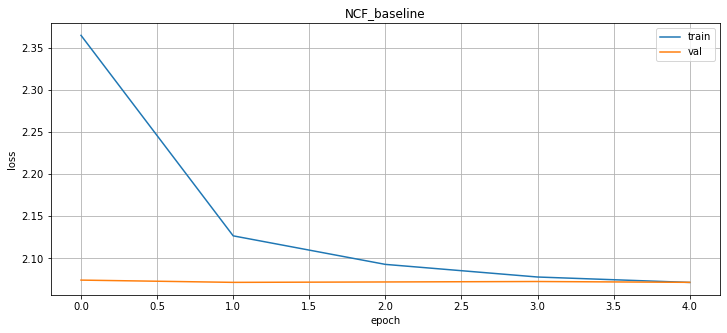

In [62]:
plot_losses(train_losses, val_losses, title="NCF_baseline")

In [17]:
def collect_predictions(model, dataloader, device):
    model.eval()
    model = model.to(device)
    torch.set_grad_enabled(False)

    preds = []
    
    for batch in tqdm(dataloader, total=len(dataloader)):
        us, its, ys_true = batch

        ys_pred = model(us.to(device), its.to(device))
        preds.extend(ys_pred.numpy().tolist())
        
    return preds

In [64]:
y_test_pred = collect_predictions(model, dataloader_val, device)

100%|████████████████████████████████████████| 686/686 [00:01<00:00, 633.86it/s]


# Валидация модели

### 3 полносвязных слоя

In [72]:
X_train, X_test, y_train, y_test = train_test_split(dataframe.drop(columns = ['rating','ts']), dataframe.rating, test_size=0.2, random_state=42, shuffle = False)

TrainDataset = RatingsDataset(X_train, y_train)
ValDataset = RatingsDataset(X_test.reset_index(drop = True), y_test.reset_index(drop = True))

In [73]:
num_epochs = 5
batch_size = 128
lr = 3e-4

In [74]:
dataloader_train = DataLoader(TrainDataset, 
                              collate_fn=RatingsDataset.collate, 
                              batch_size=batch_size, shuffle=True, drop_last=True, 
                              num_workers=4, pin_memory=True)

dataloader_val = DataLoader(ValDataset, 
                            collate_fn=RatingsDataset.collate, 
                            batch_size=batch_size, shuffle=False, drop_last=False, 
                            num_workers=4, pin_memory=True)

In [75]:
model = NeuralCF(n_users, n_items, n_factors = 100, hidden_layers_sizes = [64, 64, 64], 
        activations = ["elu", "elu", "elu"], dropouts = [True, True, True], minmax = (0,10))
loss_fn = RMSELoss
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [76]:
train_losses, val_losses, best_val_loss, model = run_experiment(
    model, dataloader_train, dataloader_val, loss_fn, optimizer, num_epochs, device, "./")

epoch: 000 | train: 100%|███████████████████| 2742/2742 [03:50<00:00, 11.92it/s]
epoch: 000 | val  : 100%|████████████████████| 686/686 [00:01<00:00, 473.10it/s]


epoch: 000 | train_loss: 2.134, val_loss: 2.079 (best:   inf)
New checkpoint saved to ./epoch=00_valloss=2.079.pth.tar



epoch: 001 | train: 100%|███████████████████| 2742/2742 [04:22<00:00, 10.45it/s]
epoch: 001 | val  : 100%|████████████████████| 686/686 [00:01<00:00, 352.48it/s]


epoch: 001 | train_loss: 2.084, val_loss: 2.072 (best: 2.079)
New checkpoint saved to ./epoch=01_valloss=2.072.pth.tar



epoch: 002 | train: 100%|███████████████████| 2742/2742 [04:54<00:00,  9.33it/s]
epoch: 002 | val  : 100%|████████████████████| 686/686 [00:01<00:00, 388.78it/s]


epoch: 002 | train_loss: 2.077, val_loss: 2.072 (best: 2.072)
New checkpoint saved to ./epoch=02_valloss=2.072.pth.tar



epoch: 003 | train: 100%|███████████████████| 2742/2742 [05:18<00:00,  8.60it/s]
epoch: 003 | val  : 100%|████████████████████| 686/686 [00:01<00:00, 380.99it/s]


epoch: 003 | train_loss: 2.075, val_loss: 2.071 (best: 2.072)
New checkpoint saved to ./epoch=03_valloss=2.071.pth.tar



epoch: 004 | train: 100%|███████████████████| 2742/2742 [05:27<00:00,  8.36it/s]
epoch: 004 | val  : 100%|████████████████████| 686/686 [00:01<00:00, 369.95it/s]


epoch: 004 | train_loss: 2.073, val_loss: 2.072 (best: 2.071)

Best val_loss = 2.071 reached at epoch 3


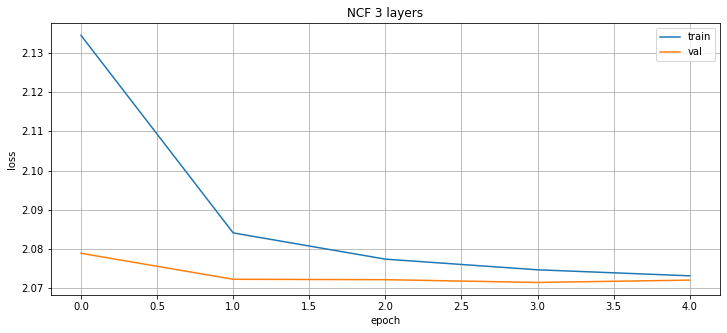

In [79]:
plot_losses(train_losses, val_losses, title="NCF 3 layers")

#### Выберем по кросс-валидации оптимальную функцию активации: relu, elu или swish

In [82]:
cv = KFold(n_splits = 3)

##### relu

In [90]:
val_losses_KFold_relu = []
train_losses_KFold_relu = []
models_KFold = list(np.zeros(cv.get_n_splits()))
i = 0

for train_index, test_index in cv.split(dataframe.drop(columns = ['rating','ts'])):
    x_train, x_test = dataframe.drop(columns = ['rating','ts']).iloc[train_index], dataframe.drop(columns = ['rating','ts']).iloc[test_index]
    y_train, y_test = dataframe['rating'].iloc[train_index], dataframe['rating'].iloc[test_index]
    
    TrainDataset = RatingsDataset(x_train.reset_index(drop = True), y_train.reset_index(drop = True))
    ValDataset = RatingsDataset(x_test.reset_index(drop = True), y_test.reset_index(drop = True))
    
    dataloader_train = DataLoader(TrainDataset, 
                              collate_fn=RatingsDataset.collate, 
                              batch_size=batch_size, shuffle=True, drop_last=True, 
                              num_workers=4, pin_memory=True)

    dataloader_val = DataLoader(ValDataset, 
                            collate_fn=RatingsDataset.collate, 
                            batch_size=batch_size, shuffle=False, drop_last=False, 
                            num_workers=4, pin_memory=True)
    
    models_KFold[i] = NeuralCF(n_users, n_items, n_factors = 20, hidden_layers_sizes = [32, 32, 32], 
        activations = ["relu", "relu", "relu"], dropouts = [True, True, True], minmax = (0,10))

    optimizer = torch.optim.Adam(models_KFold[i].parameters(), lr = lr)
    
    train_losses, val_losses, best_val_loss, models_KFold[i] = run_experiment(
    models_KFold[i], dataloader_train, dataloader_val, loss_fn, optimizer, num_epochs, device, "./")
    
    train_losses_KFold_relu.append(train_losses[-1])
    val_losses_KFold_relu.append(best_val_loss)
    
    i += 1
    

epoch: 000 | train: 100%|███████████████████| 2285/2285 [00:46<00:00, 49.67it/s]
epoch: 000 | val  : 100%|██████████████████| 1143/1143 [00:01<00:00, 672.00it/s]


epoch: 000 | train_loss: 2.236, val_loss: 2.046 (best:   inf)
New checkpoint saved to ./epoch=00_valloss=2.046.pth.tar



epoch: 001 | train: 100%|███████████████████| 2285/2285 [00:44<00:00, 51.54it/s]
epoch: 001 | val  : 100%|██████████████████| 1143/1143 [00:01<00:00, 632.65it/s]


epoch: 001 | train_loss: 2.121, val_loss: 2.041 (best: 2.046)
New checkpoint saved to ./epoch=01_valloss=2.041.pth.tar



epoch: 002 | train: 100%|███████████████████| 2285/2285 [00:44<00:00, 51.30it/s]
epoch: 002 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 559.57it/s]


epoch: 002 | train_loss: 2.102, val_loss: 2.041 (best: 2.041)



epoch: 003 | train: 100%|███████████████████| 2285/2285 [00:45<00:00, 49.68it/s]
epoch: 003 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 531.91it/s]


epoch: 003 | train_loss: 2.093, val_loss: 2.041 (best: 2.041)
New checkpoint saved to ./epoch=03_valloss=2.041.pth.tar



epoch: 004 | train: 100%|███████████████████| 2285/2285 [00:47<00:00, 48.01it/s]
epoch: 004 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 510.53it/s]


epoch: 004 | train_loss: 2.088, val_loss: 2.040 (best: 2.041)
New checkpoint saved to ./epoch=04_valloss=2.040.pth.tar

Best val_loss = 2.040 reached at epoch 4


epoch: 000 | train: 100%|███████████████████| 2285/2285 [00:48<00:00, 47.38it/s]
epoch: 000 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 482.73it/s]


epoch: 000 | train_loss: 2.277, val_loss: 2.089 (best:   inf)
New checkpoint saved to ./epoch=00_valloss=2.089.pth.tar



epoch: 001 | train: 100%|███████████████████| 2285/2285 [00:48<00:00, 47.47it/s]
epoch: 001 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 471.65it/s]


epoch: 001 | train_loss: 2.117, val_loss: 2.088 (best: 2.089)
New checkpoint saved to ./epoch=01_valloss=2.088.pth.tar



epoch: 002 | train: 100%|███████████████████| 2285/2285 [00:49<00:00, 46.20it/s]
epoch: 002 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 470.24it/s]


epoch: 002 | train_loss: 2.089, val_loss: 2.088 (best: 2.088)
New checkpoint saved to ./epoch=02_valloss=2.088.pth.tar



epoch: 003 | train: 100%|███████████████████| 2285/2285 [00:50<00:00, 45.22it/s]
epoch: 003 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 458.12it/s]


epoch: 003 | train_loss: 2.076, val_loss: 2.088 (best: 2.088)
New checkpoint saved to ./epoch=03_valloss=2.088.pth.tar



epoch: 004 | train: 100%|███████████████████| 2285/2285 [00:52<00:00, 43.28it/s]
epoch: 004 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 445.86it/s]


epoch: 004 | train_loss: 2.068, val_loss: 2.088 (best: 2.088)
New checkpoint saved to ./epoch=04_valloss=2.088.pth.tar

Best val_loss = 2.088 reached at epoch 4


epoch: 000 | train: 100%|███████████████████| 2285/2285 [00:52<00:00, 43.37it/s]
epoch: 000 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 435.12it/s]


epoch: 000 | train_loss: 2.232, val_loss: 2.067 (best:   inf)
New checkpoint saved to ./epoch=00_valloss=2.067.pth.tar



epoch: 001 | train: 100%|███████████████████| 2285/2285 [01:00<00:00, 37.68it/s]
epoch: 001 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 423.25it/s]


epoch: 001 | train_loss: 2.109, val_loss: 2.067 (best: 2.067)



epoch: 002 | train: 100%|███████████████████| 2285/2285 [00:55<00:00, 41.33it/s]
epoch: 002 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 430.29it/s]


epoch: 002 | train_loss: 2.090, val_loss: 2.067 (best: 2.067)
New checkpoint saved to ./epoch=02_valloss=2.067.pth.tar



epoch: 003 | train: 100%|███████████████████| 2285/2285 [00:55<00:00, 41.06it/s]
epoch: 003 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 404.50it/s]


epoch: 003 | train_loss: 2.081, val_loss: 2.067 (best: 2.067)
New checkpoint saved to ./epoch=03_valloss=2.067.pth.tar



epoch: 004 | train: 100%|███████████████████| 2285/2285 [00:58<00:00, 39.25it/s]
epoch: 004 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 404.57it/s]

epoch: 004 | train_loss: 2.076, val_loss: 2.067 (best: 2.067)

Best val_loss = 2.067 reached at epoch 3


##### elu

In [94]:
val_losses_KFold_elu = []
train_losses_KFold_elu = []
models_KFold = list(np.zeros(cv.get_n_splits()))
i = 0

for train_index, test_index in cv.split(dataframe.drop(columns = ['rating','ts'])):
    x_train, x_test = dataframe.drop(columns = ['rating','ts']).iloc[train_index], dataframe.drop(columns = ['rating','ts']).iloc[test_index]
    y_train, y_test = dataframe['rating'].iloc[train_index], dataframe['rating'].iloc[test_index]
    
    TrainDataset = RatingsDataset(x_train.reset_index(drop = True), y_train.reset_index(drop = True))
    ValDataset = RatingsDataset(x_test.reset_index(drop = True), y_test.reset_index(drop = True))
    
    dataloader_train = DataLoader(TrainDataset, 
                              collate_fn=RatingsDataset.collate, 
                              batch_size=batch_size, shuffle=True, drop_last=True, 
                              num_workers=4, pin_memory=True)

    dataloader_val = DataLoader(ValDataset, 
                            collate_fn=RatingsDataset.collate, 
                            batch_size=batch_size, shuffle=False, drop_last=False, 
                            num_workers=4, pin_memory=True)
    
    models_KFold[i] = NeuralCF(n_users, n_items, n_factors = 20, hidden_layers_sizes = [32, 32, 32], 
        activations = ["elu", "elu", "elu"], dropouts = [True, True, True], minmax = (0,10))

    optimizer = torch.optim.Adam(models_KFold[i].parameters(), lr = lr)
    
    train_losses, val_losses, best_val_loss, models_KFold[i] = run_experiment(
    models_KFold[i], dataloader_train, dataloader_val, loss_fn, optimizer, num_epochs, device, "./")
    
    train_losses_KFold_elu.append(train_losses[-1])
    val_losses_KFold_elu.append(best_val_loss)
    
    i += 1
    

epoch: 000 | train: 100%|███████████████████| 2285/2285 [00:52<00:00, 43.92it/s]
epoch: 000 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 444.82it/s]


epoch: 000 | train_loss: 2.226, val_loss: 2.040 (best:   inf)
New checkpoint saved to ./epoch=00_valloss=2.040.pth.tar



epoch: 001 | train: 100%|███████████████████| 2285/2285 [00:53<00:00, 42.58it/s]
epoch: 001 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 434.84it/s]


epoch: 001 | train_loss: 2.110, val_loss: 2.041 (best: 2.040)



epoch: 002 | train: 100%|███████████████████| 2285/2285 [00:54<00:00, 42.19it/s]
epoch: 002 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 417.13it/s]


epoch: 002 | train_loss: 2.098, val_loss: 2.044 (best: 2.040)



epoch: 003 | train: 100%|███████████████████| 2285/2285 [00:56<00:00, 40.36it/s]
epoch: 003 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 425.48it/s]


epoch: 003 | train_loss: 2.093, val_loss: 2.041 (best: 2.040)



epoch: 004 | train: 100%|███████████████████| 2285/2285 [00:55<00:00, 41.20it/s]
epoch: 004 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 424.84it/s]


epoch: 004 | train_loss: 2.089, val_loss: 2.041 (best: 2.040)

Best val_loss = 2.040 reached at epoch 0


epoch: 000 | train: 100%|███████████████████| 2285/2285 [00:53<00:00, 43.06it/s]
epoch: 000 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 410.18it/s]


epoch: 000 | train_loss: 2.200, val_loss: 2.093 (best:   inf)
New checkpoint saved to ./epoch=00_valloss=2.093.pth.tar



epoch: 001 | train: 100%|███████████████████| 2285/2285 [00:53<00:00, 42.38it/s]
epoch: 001 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 401.59it/s]


epoch: 001 | train_loss: 2.090, val_loss: 2.090 (best: 2.093)
New checkpoint saved to ./epoch=01_valloss=2.090.pth.tar



epoch: 002 | train: 100%|███████████████████| 2285/2285 [00:54<00:00, 41.92it/s]
epoch: 002 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 412.87it/s]


epoch: 002 | train_loss: 2.077, val_loss: 2.087 (best: 2.090)
New checkpoint saved to ./epoch=02_valloss=2.087.pth.tar



epoch: 003 | train: 100%|███████████████████| 2285/2285 [00:54<00:00, 41.91it/s]
epoch: 003 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 390.70it/s]


epoch: 003 | train_loss: 2.071, val_loss: 2.087 (best: 2.087)
New checkpoint saved to ./epoch=03_valloss=2.087.pth.tar



epoch: 004 | train: 100%|███████████████████| 2285/2285 [00:55<00:00, 41.47it/s]
epoch: 004 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 393.41it/s]


epoch: 004 | train_loss: 2.066, val_loss: 2.088 (best: 2.087)

Best val_loss = 2.087 reached at epoch 3


epoch: 000 | train: 100%|███████████████████| 2285/2285 [00:55<00:00, 41.26it/s]
epoch: 000 | val  : 100%|██████████████████| 1143/1143 [00:03<00:00, 333.51it/s]


epoch: 000 | train_loss: 2.218, val_loss: 2.067 (best:   inf)
New checkpoint saved to ./epoch=00_valloss=2.067.pth.tar



epoch: 001 | train: 100%|███████████████████| 2285/2285 [01:02<00:00, 36.69it/s]
epoch: 001 | val  : 100%|██████████████████| 1143/1143 [00:03<00:00, 362.07it/s]


epoch: 001 | train_loss: 2.100, val_loss: 2.067 (best: 2.067)
New checkpoint saved to ./epoch=01_valloss=2.067.pth.tar



epoch: 002 | train: 100%|███████████████████| 2285/2285 [00:59<00:00, 38.38it/s]
epoch: 002 | val  : 100%|██████████████████| 1143/1143 [00:03<00:00, 326.16it/s]


epoch: 002 | train_loss: 2.088, val_loss: 2.067 (best: 2.067)
New checkpoint saved to ./epoch=02_valloss=2.067.pth.tar



epoch: 003 | train: 100%|███████████████████| 2285/2285 [01:02<00:00, 36.81it/s]
epoch: 003 | val  : 100%|██████████████████| 1143/1143 [00:03<00:00, 368.27it/s]


epoch: 003 | train_loss: 2.082, val_loss: 2.067 (best: 2.067)



epoch: 004 | train: 100%|███████████████████| 2285/2285 [00:58<00:00, 39.13it/s]
epoch: 004 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 403.45it/s]


epoch: 004 | train_loss: 2.078, val_loss: 2.067 (best: 2.067)

Best val_loss = 2.067 reached at epoch 2


In [100]:
val_losses_KFold_swish = []
train_losses_KFold_swish = []
models_KFold = list(np.zeros(cv.get_n_splits()))
i = 0

for train_index, test_index in cv.split(dataframe.drop(columns = ['rating','ts'])):
    x_train, x_test = dataframe.drop(columns = ['rating','ts']).iloc[train_index], dataframe.drop(columns = ['rating','ts']).iloc[test_index]
    y_train, y_test = dataframe['rating'].iloc[train_index], dataframe['rating'].iloc[test_index]
    
    TrainDataset = RatingsDataset(x_train.reset_index(drop = True), y_train.reset_index(drop = True))
    ValDataset = RatingsDataset(x_test.reset_index(drop = True), y_test.reset_index(drop = True))
    
    dataloader_train = DataLoader(TrainDataset, 
                              collate_fn=RatingsDataset.collate, 
                              batch_size=batch_size, shuffle=True, drop_last=True, 
                              num_workers=4, pin_memory=True)

    dataloader_val = DataLoader(ValDataset, 
                            collate_fn=RatingsDataset.collate, 
                            batch_size=batch_size, shuffle=False, drop_last=False, 
                            num_workers=4, pin_memory=True)
    
    models_KFold[i] = NeuralCF(n_users, n_items, n_factors = 20, hidden_layers_sizes = [32, 32, 32], 
        activations = ["swish", "swish", "swish"], dropouts = [True, True, True], minmax = (0,10))

    optimizer = torch.optim.Adam(models_KFold[i].parameters(), lr = lr)
    
    train_losses, val_losses, best_val_loss, models_KFold[i] = run_experiment(
    models_KFold[i], dataloader_train, dataloader_val, loss_fn, optimizer, num_epochs, device, "./")
    
    train_losses_KFold_swish.append(train_losses[-1])
    val_losses_KFold_swish.append(best_val_loss)
    
    i += 1

epoch: 000 | train: 100%|███████████████████| 2285/2285 [00:45<00:00, 50.07it/s]
epoch: 000 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 484.02it/s]


epoch: 000 | train_loss: 2.284, val_loss: 2.041 (best:   inf)
New checkpoint saved to ./epoch=00_valloss=2.041.pth.tar



epoch: 001 | train: 100%|███████████████████| 2285/2285 [00:49<00:00, 45.90it/s]
epoch: 001 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 422.25it/s]


epoch: 001 | train_loss: 2.118, val_loss: 2.040 (best: 2.041)
New checkpoint saved to ./epoch=01_valloss=2.040.pth.tar



epoch: 002 | train: 100%|███████████████████| 2285/2285 [00:50<00:00, 45.18it/s]
epoch: 002 | val  : 100%|██████████████████| 1143/1143 [00:03<00:00, 380.09it/s]


epoch: 002 | train_loss: 2.108, val_loss: 2.040 (best: 2.040)
New checkpoint saved to ./epoch=02_valloss=2.040.pth.tar



epoch: 003 | train: 100%|███████████████████| 2285/2285 [00:52<00:00, 43.12it/s]
epoch: 003 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 415.50it/s]


epoch: 003 | train_loss: 2.100, val_loss: 2.040 (best: 2.040)
New checkpoint saved to ./epoch=03_valloss=2.040.pth.tar



epoch: 004 | train: 100%|███████████████████| 2285/2285 [00:55<00:00, 41.14it/s]
epoch: 004 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 381.85it/s]


epoch: 004 | train_loss: 2.094, val_loss: 2.040 (best: 2.040)

Best val_loss = 2.040 reached at epoch 3


epoch: 000 | train: 100%|███████████████████| 2285/2285 [00:55<00:00, 41.23it/s]
epoch: 000 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 412.70it/s]


epoch: 000 | train_loss: 2.196, val_loss: 2.094 (best:   inf)
New checkpoint saved to ./epoch=00_valloss=2.094.pth.tar



epoch: 001 | train: 100%|███████████████████| 2285/2285 [00:56<00:00, 40.29it/s]
epoch: 001 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 417.92it/s]


epoch: 001 | train_loss: 2.084, val_loss: 2.088 (best: 2.094)
New checkpoint saved to ./epoch=01_valloss=2.088.pth.tar



epoch: 002 | train: 100%|███████████████████| 2285/2285 [00:58<00:00, 39.29it/s]
epoch: 002 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 415.69it/s]


epoch: 002 | train_loss: 2.076, val_loss: 2.088 (best: 2.088)
New checkpoint saved to ./epoch=02_valloss=2.088.pth.tar



epoch: 003 | train: 100%|███████████████████| 2285/2285 [00:54<00:00, 42.00it/s]
epoch: 003 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 400.41it/s]


epoch: 003 | train_loss: 2.071, val_loss: 2.088 (best: 2.088)



epoch: 004 | train: 100%|███████████████████| 2285/2285 [00:57<00:00, 39.94it/s]
epoch: 004 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 427.10it/s]


epoch: 004 | train_loss: 2.066, val_loss: 2.088 (best: 2.088)
New checkpoint saved to ./epoch=04_valloss=2.088.pth.tar

Best val_loss = 2.088 reached at epoch 4


epoch: 000 | train: 100%|███████████████████| 2285/2285 [00:50<00:00, 45.34it/s]
epoch: 000 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 433.10it/s]


epoch: 000 | train_loss: 2.215, val_loss: 2.067 (best:   inf)
New checkpoint saved to ./epoch=00_valloss=2.067.pth.tar



epoch: 001 | train: 100%|███████████████████| 2285/2285 [00:52<00:00, 43.91it/s]
epoch: 001 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 429.81it/s]


epoch: 001 | train_loss: 2.097, val_loss: 2.067 (best: 2.067)



epoch: 002 | train: 100%|███████████████████| 2285/2285 [00:52<00:00, 43.75it/s]
epoch: 002 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 426.54it/s]


epoch: 002 | train_loss: 2.088, val_loss: 2.066 (best: 2.067)
New checkpoint saved to ./epoch=02_valloss=2.066.pth.tar



epoch: 003 | train: 100%|███████████████████| 2285/2285 [00:52<00:00, 43.32it/s]
epoch: 003 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 423.34it/s]


epoch: 003 | train_loss: 2.082, val_loss: 2.067 (best: 2.066)



epoch: 004 | train: 100%|███████████████████| 2285/2285 [00:52<00:00, 43.66it/s]
epoch: 004 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 429.14it/s]

epoch: 004 | train_loss: 2.078, val_loss: 2.067 (best: 2.066)

Best val_loss = 2.066 reached at epoch 2


Сравним результаты

Посмотрим на среднее значение RMSE на обучающих выборках

In [123]:
print(np.mean(train_losses_KFold_relu))

2.0773487205143657


In [124]:
print(np.mean(train_losses_KFold_elu))

2.077614712315176


In [125]:
print(np.mean(train_losses_KFold_swish))

2.079531498602235


Посмотрим на среднее значение RMSE на валидационных выборках

In [126]:
print(np.mean(val_losses_KFold_relu))

2.0647565019690424


In [127]:
print(np.mean(val_losses_KFold_elu))

2.0646013982374556


In [128]:
print(np.mean(val_losses_KFold_swish))

2.0647608983895633


##### Вывод: 
Можем наблюдать, что резльтаты примерно одинаковые и отличаются незначительно. На используемом датасете быстрее модель обучалась при применении relu, так как среднее качество на обучающих выборках при применении relu оказалось наилучшем в смысле RMSE. При этом лучшее среднее качество на валидационных выборках показала elu. Также стоит отметить, что хуже всех себя показала третья функция активации swish(дейсительно, она больше подходит для глубоких нейронных сетей). Будем импользовать elu для 3 слоёв

### 5 полносвязных слоёв

#### Выберем по кросс-валидации оптимальную функцию активации: relu, elu или swish

In [106]:
num_epochs = 5
batch_size = 128
lr = 3e-4

In [107]:
cv = KFold(n_splits = 3)

In [108]:
val_losses_KFold_relu_5 = []
train_losses_KFold_relu_5 = []
models_KFold = list(np.zeros(cv.get_n_splits()))
i = 0

for train_index, test_index in cv.split(dataframe.drop(columns = ['rating','ts'])):
    x_train, x_test = dataframe.drop(columns = ['rating','ts']).iloc[train_index], dataframe.drop(columns = ['rating','ts']).iloc[test_index]
    y_train, y_test = dataframe['rating'].iloc[train_index], dataframe['rating'].iloc[test_index]
    
    TrainDataset = RatingsDataset(x_train.reset_index(drop = True), y_train.reset_index(drop = True))
    ValDataset = RatingsDataset(x_test.reset_index(drop = True), y_test.reset_index(drop = True))
    
    dataloader_train = DataLoader(TrainDataset, 
                              collate_fn=RatingsDataset.collate, 
                              batch_size=batch_size, shuffle=True, drop_last=True, 
                              num_workers=4, pin_memory=True)

    dataloader_val = DataLoader(ValDataset, 
                            collate_fn=RatingsDataset.collate, 
                            batch_size=batch_size, shuffle=False, drop_last=False, 
                            num_workers=4, pin_memory=True)
    
    models_KFold[i] = NeuralCF(n_users, n_items, n_factors = 10, hidden_layers_sizes = [16, 16, 16, 16, 16], 
        activations = ["relu", "relu", "relu", "relu", "relu"], dropouts = [True, True, True, True, True], minmax = (0,10))

    optimizer = torch.optim.Adam(models_KFold[i].parameters(), lr = lr)
    
    train_losses, val_losses, best_val_loss, models_KFold[i] = run_experiment(
    models_KFold[i], dataloader_train, dataloader_val, loss_fn, optimizer, num_epochs, device, "./")
    
    train_losses_KFold_relu_5.append(train_losses[-1])
    val_losses_KFold_relu_5.append(best_val_loss)
    
    i += 1

epoch: 000 | train: 100%|███████████████████| 2285/2285 [00:28<00:00, 80.15it/s]
epoch: 000 | val  : 100%|██████████████████| 1143/1143 [00:01<00:00, 580.49it/s]


epoch: 000 | train_loss: 2.278, val_loss: 2.043 (best:   inf)
New checkpoint saved to ./epoch=00_valloss=2.043.pth.tar



epoch: 001 | train: 100%|███████████████████| 2285/2285 [00:27<00:00, 82.94it/s]
epoch: 001 | val  : 100%|██████████████████| 1143/1143 [00:01<00:00, 604.65it/s]


epoch: 001 | train_loss: 2.129, val_loss: 2.041 (best: 2.043)
New checkpoint saved to ./epoch=01_valloss=2.041.pth.tar



epoch: 002 | train: 100%|███████████████████| 2285/2285 [00:28<00:00, 80.33it/s]
epoch: 002 | val  : 100%|██████████████████| 1143/1143 [00:01<00:00, 618.83it/s]


epoch: 002 | train_loss: 2.103, val_loss: 2.042 (best: 2.041)



epoch: 003 | train: 100%|███████████████████| 2285/2285 [00:27<00:00, 83.36it/s]
epoch: 003 | val  : 100%|██████████████████| 1143/1143 [00:01<00:00, 620.55it/s]


epoch: 003 | train_loss: 2.090, val_loss: 2.042 (best: 2.041)



epoch: 004 | train: 100%|███████████████████| 2285/2285 [00:27<00:00, 83.29it/s]
epoch: 004 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 472.57it/s]


epoch: 004 | train_loss: 2.084, val_loss: 2.041 (best: 2.041)

Best val_loss = 2.041 reached at epoch 1


epoch: 000 | train: 100%|███████████████████| 2285/2285 [00:28<00:00, 80.11it/s]
epoch: 000 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 551.65it/s]


epoch: 000 | train_loss: 2.279, val_loss: 2.087 (best:   inf)
New checkpoint saved to ./epoch=00_valloss=2.087.pth.tar



epoch: 001 | train: 100%|███████████████████| 2285/2285 [00:27<00:00, 82.16it/s]
epoch: 001 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 567.64it/s]


epoch: 001 | train_loss: 2.104, val_loss: 2.087 (best: 2.087)



epoch: 002 | train: 100%|███████████████████| 2285/2285 [00:27<00:00, 82.35it/s]
epoch: 002 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 545.10it/s]


epoch: 002 | train_loss: 2.080, val_loss: 2.088 (best: 2.087)



epoch: 003 | train: 100%|███████████████████| 2285/2285 [00:28<00:00, 79.68it/s]
epoch: 003 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 540.36it/s]


epoch: 003 | train_loss: 2.068, val_loss: 2.087 (best: 2.087)



epoch: 004 | train: 100%|███████████████████| 2285/2285 [00:28<00:00, 79.19it/s]
epoch: 004 | val  : 100%|██████████████████| 1143/1143 [00:01<00:00, 579.34it/s]


epoch: 004 | train_loss: 2.063, val_loss: 2.087 (best: 2.087)
New checkpoint saved to ./epoch=04_valloss=2.087.pth.tar

Best val_loss = 2.087 reached at epoch 4


epoch: 000 | train: 100%|███████████████████| 2285/2285 [00:27<00:00, 84.57it/s]
epoch: 000 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 556.97it/s]


epoch: 000 | train_loss: 2.479, val_loss: 2.067 (best:   inf)
New checkpoint saved to ./epoch=00_valloss=2.067.pth.tar



epoch: 001 | train: 100%|███████████████████| 2285/2285 [00:28<00:00, 79.25it/s]
epoch: 001 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 554.62it/s]


epoch: 001 | train_loss: 2.169, val_loss: 2.067 (best: 2.067)



epoch: 002 | train: 100%|███████████████████| 2285/2285 [00:28<00:00, 79.69it/s]
epoch: 002 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 526.24it/s]


epoch: 002 | train_loss: 2.110, val_loss: 2.067 (best: 2.067)



epoch: 003 | train: 100%|███████████████████| 2285/2285 [00:28<00:00, 78.82it/s]
epoch: 003 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 559.33it/s]


epoch: 003 | train_loss: 2.086, val_loss: 2.067 (best: 2.067)



epoch: 004 | train: 100%|███████████████████| 2285/2285 [00:28<00:00, 78.87it/s]
epoch: 004 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 563.11it/s]

epoch: 004 | train_loss: 2.075, val_loss: 2.067 (best: 2.067)

Best val_loss = 2.067 reached at epoch 0


In [109]:
val_losses_KFold_elu_5 = []
train_losses_KFold_elu_5 = []
models_KFold = list(np.zeros(cv.get_n_splits()))
i = 0

for train_index, test_index in cv.split(dataframe.drop(columns = ['rating','ts'])):
    x_train, x_test = dataframe.drop(columns = ['rating','ts']).iloc[train_index], dataframe.drop(columns = ['rating','ts']).iloc[test_index]
    y_train, y_test = dataframe['rating'].iloc[train_index], dataframe['rating'].iloc[test_index]
    
    TrainDataset = RatingsDataset(x_train.reset_index(drop = True), y_train.reset_index(drop = True))
    ValDataset = RatingsDataset(x_test.reset_index(drop = True), y_test.reset_index(drop = True))
    
    dataloader_train = DataLoader(TrainDataset, 
                              collate_fn=RatingsDataset.collate, 
                              batch_size=batch_size, shuffle=True, drop_last=True, 
                              num_workers=4, pin_memory=True)

    dataloader_val = DataLoader(ValDataset, 
                            collate_fn=RatingsDataset.collate, 
                            batch_size=batch_size, shuffle=False, drop_last=False, 
                            num_workers=4, pin_memory=True)
    
    models_KFold[i] = NeuralCF(n_users, n_items, n_factors = 10, hidden_layers_sizes = [16, 16, 16, 16, 16], 
        activations = ["elu", "elu", "elu", "elu", "elu"], dropouts = [True, True, True, True, True], minmax = (0,10))

    optimizer = torch.optim.Adam(models_KFold[i].parameters(), lr = lr)
    
    train_losses, val_losses, best_val_loss, models_KFold[i] = run_experiment(
    models_KFold[i], dataloader_train, dataloader_val, loss_fn, optimizer, num_epochs, device, "./")
    
    train_losses_KFold_elu_5.append(train_losses[-1])
    val_losses_KFold_elu_5.append(best_val_loss)
    
    i += 1

epoch: 000 | train: 100%|███████████████████| 2285/2285 [00:30<00:00, 75.83it/s]
epoch: 000 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 433.88it/s]


epoch: 000 | train_loss: 2.219, val_loss: 2.040 (best:   inf)
New checkpoint saved to ./epoch=00_valloss=2.040.pth.tar



epoch: 001 | train: 100%|███████████████████| 2285/2285 [00:34<00:00, 66.75it/s]
epoch: 001 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 460.14it/s]


epoch: 001 | train_loss: 2.116, val_loss: 2.041 (best: 2.040)



epoch: 002 | train: 100%|███████████████████| 2285/2285 [00:36<00:00, 62.88it/s]
epoch: 002 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 431.18it/s]


epoch: 002 | train_loss: 2.097, val_loss: 2.040 (best: 2.040)
New checkpoint saved to ./epoch=02_valloss=2.040.pth.tar



epoch: 003 | train: 100%|███████████████████| 2285/2285 [00:37<00:00, 61.47it/s]
epoch: 003 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 445.64it/s]


epoch: 003 | train_loss: 2.089, val_loss: 2.042 (best: 2.040)



epoch: 004 | train: 100%|███████████████████| 2285/2285 [00:37<00:00, 60.85it/s]
epoch: 004 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 441.52it/s]


epoch: 004 | train_loss: 2.085, val_loss: 2.041 (best: 2.040)

Best val_loss = 2.040 reached at epoch 2


epoch: 000 | train: 100%|███████████████████| 2285/2285 [00:37<00:00, 60.61it/s]
epoch: 000 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 422.28it/s]


epoch: 000 | train_loss: 2.204, val_loss: 2.091 (best:   inf)
New checkpoint saved to ./epoch=00_valloss=2.091.pth.tar



epoch: 001 | train: 100%|███████████████████| 2285/2285 [00:38<00:00, 59.59it/s]
epoch: 001 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 424.06it/s]


epoch: 001 | train_loss: 2.098, val_loss: 2.087 (best: 2.091)
New checkpoint saved to ./epoch=01_valloss=2.087.pth.tar



epoch: 002 | train: 100%|███████████████████| 2285/2285 [00:38<00:00, 59.07it/s]
epoch: 002 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 413.04it/s]


epoch: 002 | train_loss: 2.078, val_loss: 2.087 (best: 2.087)
New checkpoint saved to ./epoch=02_valloss=2.087.pth.tar



epoch: 003 | train: 100%|███████████████████| 2285/2285 [00:38<00:00, 59.40it/s]
epoch: 003 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 492.20it/s]


epoch: 003 | train_loss: 2.068, val_loss: 2.087 (best: 2.087)



epoch: 004 | train: 100%|███████████████████| 2285/2285 [00:35<00:00, 63.59it/s]
epoch: 004 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 512.58it/s]


epoch: 004 | train_loss: 2.063, val_loss: 2.088 (best: 2.087)

Best val_loss = 2.087 reached at epoch 2


epoch: 000 | train: 100%|███████████████████| 2285/2285 [00:32<00:00, 69.64it/s]
epoch: 000 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 463.63it/s]


epoch: 000 | train_loss: 2.210, val_loss: 2.067 (best:   inf)
New checkpoint saved to ./epoch=00_valloss=2.067.pth.tar



epoch: 001 | train: 100%|███████████████████| 2285/2285 [00:34<00:00, 66.56it/s]
epoch: 001 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 501.06it/s]


epoch: 001 | train_loss: 2.105, val_loss: 2.067 (best: 2.067)
New checkpoint saved to ./epoch=01_valloss=2.067.pth.tar



epoch: 002 | train: 100%|███████████████████| 2285/2285 [00:30<00:00, 75.76it/s]
epoch: 002 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 539.82it/s]


epoch: 002 | train_loss: 2.085, val_loss: 2.068 (best: 2.067)



epoch: 003 | train: 100%|███████████████████| 2285/2285 [00:29<00:00, 76.99it/s]
epoch: 003 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 558.60it/s]


epoch: 003 | train_loss: 2.076, val_loss: 2.067 (best: 2.067)



epoch: 004 | train: 100%|███████████████████| 2285/2285 [00:29<00:00, 77.43it/s]
epoch: 004 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 520.11it/s]

epoch: 004 | train_loss: 2.072, val_loss: 2.067 (best: 2.067)

Best val_loss = 2.067 reached at epoch 1


In [111]:
val_losses_KFold_swish_5 = []
train_losses_KFold_swish_5 = []
models_KFold = list(np.zeros(cv.get_n_splits()))
i = 0

for train_index, test_index in cv.split(dataframe.drop(columns = ['rating','ts'])):
    x_train, x_test = dataframe.drop(columns = ['rating','ts']).iloc[train_index], dataframe.drop(columns = ['rating','ts']).iloc[test_index]
    y_train, y_test = dataframe['rating'].iloc[train_index], dataframe['rating'].iloc[test_index]
    
    TrainDataset = RatingsDataset(x_train.reset_index(drop = True), y_train.reset_index(drop = True))
    ValDataset = RatingsDataset(x_test.reset_index(drop = True), y_test.reset_index(drop = True))
    
    dataloader_train = DataLoader(TrainDataset, 
                              collate_fn=RatingsDataset.collate, 
                              batch_size=batch_size, shuffle=True, drop_last=True, 
                              num_workers=4, pin_memory=True)

    dataloader_val = DataLoader(ValDataset, 
                            collate_fn=RatingsDataset.collate, 
                            batch_size=batch_size, shuffle=False, drop_last=False, 
                            num_workers=4, pin_memory=True)
    
    models_KFold[i] = NeuralCF(n_users, n_items, n_factors = 10, hidden_layers_sizes = [16, 16, 16, 16, 16], 
        activations = ["swish", "swish", "swish", "swish", "swish"], dropouts = [True, True, True, True, True], minmax = (0,10))

    optimizer = torch.optim.Adam(models_KFold[i].parameters(), lr = lr)
    
    train_losses, val_losses, best_val_loss, models_KFold[i] = run_experiment(
    models_KFold[i], dataloader_train, dataloader_val, loss_fn, optimizer, num_epochs, device, "./")
    
    train_losses_KFold_swish_5.append(train_losses[-1])
    val_losses_KFold_swish_5.append(best_val_loss)
    
    i += 1

epoch: 000 | train: 100%|███████████████████| 2285/2285 [00:26<00:00, 86.93it/s]
epoch: 000 | val  : 100%|██████████████████| 1143/1143 [00:01<00:00, 610.13it/s]


epoch: 000 | train_loss: 2.370, val_loss: 2.042 (best:   inf)
New checkpoint saved to ./epoch=00_valloss=2.042.pth.tar



epoch: 001 | train: 100%|███████████████████| 2285/2285 [00:26<00:00, 86.73it/s]
epoch: 001 | val  : 100%|██████████████████| 1143/1143 [00:01<00:00, 602.02it/s]


epoch: 001 | train_loss: 2.145, val_loss: 2.040 (best: 2.042)
New checkpoint saved to ./epoch=01_valloss=2.040.pth.tar



epoch: 002 | train: 100%|███████████████████| 2285/2285 [00:26<00:00, 86.48it/s]
epoch: 002 | val  : 100%|██████████████████| 1143/1143 [00:01<00:00, 599.48it/s]


epoch: 002 | train_loss: 2.120, val_loss: 2.040 (best: 2.040)
New checkpoint saved to ./epoch=02_valloss=2.040.pth.tar



epoch: 003 | train: 100%|███████████████████| 2285/2285 [00:26<00:00, 85.87it/s]
epoch: 003 | val  : 100%|██████████████████| 1143/1143 [00:01<00:00, 610.97it/s]


epoch: 003 | train_loss: 2.103, val_loss: 2.041 (best: 2.040)



epoch: 004 | train: 100%|███████████████████| 2285/2285 [00:27<00:00, 84.17it/s]
epoch: 004 | val  : 100%|██████████████████| 1143/1143 [00:01<00:00, 588.40it/s]


epoch: 004 | train_loss: 2.093, val_loss: 2.041 (best: 2.040)

Best val_loss = 2.040 reached at epoch 2


epoch: 000 | train: 100%|███████████████████| 2285/2285 [00:27<00:00, 84.33it/s]
epoch: 000 | val  : 100%|██████████████████| 1143/1143 [00:01<00:00, 592.67it/s]


epoch: 000 | train_loss: 2.275, val_loss: 2.093 (best:   inf)
New checkpoint saved to ./epoch=00_valloss=2.093.pth.tar



epoch: 001 | train: 100%|███████████████████| 2285/2285 [00:27<00:00, 83.01it/s]
epoch: 001 | val  : 100%|██████████████████| 1143/1143 [00:01<00:00, 582.40it/s]


epoch: 001 | train_loss: 2.107, val_loss: 2.092 (best: 2.093)
New checkpoint saved to ./epoch=01_valloss=2.092.pth.tar



epoch: 002 | train: 100%|███████████████████| 2285/2285 [00:27<00:00, 83.00it/s]
epoch: 002 | val  : 100%|██████████████████| 1143/1143 [00:01<00:00, 573.43it/s]


epoch: 002 | train_loss: 2.088, val_loss: 2.088 (best: 2.092)
New checkpoint saved to ./epoch=02_valloss=2.088.pth.tar



epoch: 003 | train: 100%|███████████████████| 2285/2285 [00:28<00:00, 79.83it/s]
epoch: 003 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 505.40it/s]


epoch: 003 | train_loss: 2.074, val_loss: 2.087 (best: 2.088)
New checkpoint saved to ./epoch=03_valloss=2.087.pth.tar



epoch: 004 | train: 100%|███████████████████| 2285/2285 [00:30<00:00, 73.97it/s]
epoch: 004 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 560.45it/s]


epoch: 004 | train_loss: 2.066, val_loss: 2.088 (best: 2.087)

Best val_loss = 2.087 reached at epoch 3


epoch: 000 | train: 100%|███████████████████| 2285/2285 [00:28<00:00, 81.22it/s]
epoch: 000 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 556.75it/s]


epoch: 000 | train_loss: 2.334, val_loss: 2.068 (best:   inf)
New checkpoint saved to ./epoch=00_valloss=2.068.pth.tar



epoch: 001 | train: 100%|███████████████████| 2285/2285 [00:28<00:00, 78.99it/s]
epoch: 001 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 558.85it/s]


epoch: 001 | train_loss: 2.131, val_loss: 2.067 (best: 2.068)
New checkpoint saved to ./epoch=01_valloss=2.067.pth.tar



epoch: 002 | train: 100%|███████████████████| 2285/2285 [00:29<00:00, 78.38it/s]
epoch: 002 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 549.80it/s]


epoch: 002 | train_loss: 2.105, val_loss: 2.067 (best: 2.067)



epoch: 003 | train: 100%|███████████████████| 2285/2285 [00:29<00:00, 76.58it/s]
epoch: 003 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 549.68it/s]


epoch: 003 | train_loss: 2.089, val_loss: 2.068 (best: 2.067)



epoch: 004 | train: 100%|███████████████████| 2285/2285 [00:29<00:00, 76.39it/s]
epoch: 004 | val  : 100%|██████████████████| 1143/1143 [00:02<00:00, 515.82it/s]

epoch: 004 | train_loss: 2.079, val_loss: 2.067 (best: 2.067)

Best val_loss = 2.067 reached at epoch 1


Сравним результаты

Посмотрим на среднее значение RMSE на обучающих выборках

In [130]:
print(np.mean(train_losses_KFold_relu_5))

print(np.mean(train_losses_KFold_elu_5))

print(np.mean(train_losses_KFold_swish_5))

2.0740067820058607
2.073412503055375
2.0794332146905443


Посмотрим на среднее значение RMSE на валидационных выборках

In [131]:
print(np.mean(val_losses_KFold_relu_5))

print(np.mean(val_losses_KFold_elu_5))

print(np.mean(val_losses_KFold_swish_5))

2.0649241066145874
2.064648535481762
2.064598144056777


##### Вывод: 
На используемом датасете быстрее модель обучалась при применении elu, так как среднее качество на обучающих выборках при применении relu оказалось наилучшем в смысле RMSE. При этом лучшее среднее качество на валидационных выборках показала swish. Да, такой результат и ожидали получить. Так как теперь в модели уже 5 полносвязных слоёв, а swish больше подходит для глубоких нейронных сетей. Будем импользовать swish для 5 слоёв

In [132]:
num_epochs = 5
batch_size = 128
lr = 3e-4

In [133]:
X_train, X_test, y_train, y_test = train_test_split(dataframe.drop(columns = ['rating','ts']), dataframe.rating, test_size=0.2, random_state=42, shuffle = False)

TrainDataset = RatingsDataset(X_train, y_train)
ValDataset = RatingsDataset(X_test.reset_index(drop = True), y_test.reset_index(drop = True))

In [134]:
num_epochs = 5
batch_size = 128
lr = 3e-4

In [135]:
dataloader_train = DataLoader(TrainDataset, 
                              collate_fn=RatingsDataset.collate, 
                              batch_size=batch_size, shuffle=True, drop_last=True, 
                              num_workers=4, pin_memory=True)

dataloader_val = DataLoader(ValDataset, 
                            collate_fn=RatingsDataset.collate, 
                            batch_size=batch_size, shuffle=False, drop_last=False, 
                            num_workers=4, pin_memory=True)

### Сравним теперь результаты модели с 5 слоями с подобранной функцией активации с результатами модели с 3 слоями с подобранной функцией активации, считая, что остальные параметры фиксированы

In [138]:
model = NeuralCF(n_users, n_items, n_factors = 100, hidden_layers_sizes = [64, 64, 64, 64, 64], 
        activations = ["swish", "swish", "swish", 'swish', "swish"], dropouts = [True, True, True, True, True], minmax = (0,10))
loss_fn = RMSELoss
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [139]:
train_losses, val_losses, best_val_loss, model = run_experiment(
    model, dataloader_train, dataloader_val, loss_fn, optimizer, num_epochs, device, "./")

epoch: 000 | train: 100%|███████████████████| 2742/2742 [04:00<00:00, 11.42it/s]
epoch: 000 | val  : 100%|████████████████████| 686/686 [00:01<00:00, 348.00it/s]


epoch: 000 | train_loss: 2.147, val_loss: 2.073 (best:   inf)
New checkpoint saved to ./epoch=00_valloss=2.073.pth.tar



epoch: 001 | train: 100%|███████████████████| 2742/2742 [05:05<00:00,  8.97it/s]
epoch: 001 | val  : 100%|████████████████████| 686/686 [00:01<00:00, 361.01it/s]


epoch: 001 | train_loss: 2.086, val_loss: 2.072 (best: 2.073)
New checkpoint saved to ./epoch=01_valloss=2.072.pth.tar



epoch: 002 | train: 100%|███████████████████| 2742/2742 [05:27<00:00,  8.37it/s]
epoch: 002 | val  : 100%|████████████████████| 686/686 [00:02<00:00, 336.55it/s]


epoch: 002 | train_loss: 2.082, val_loss: 2.071 (best: 2.072)
New checkpoint saved to ./epoch=02_valloss=2.071.pth.tar



epoch: 003 | train: 100%|███████████████████| 2742/2742 [05:42<00:00,  8.01it/s]
epoch: 003 | val  : 100%|████████████████████| 686/686 [00:02<00:00, 325.56it/s]


epoch: 003 | train_loss: 2.080, val_loss: 2.071 (best: 2.071)



epoch: 004 | train: 100%|███████████████████| 2742/2742 [05:46<00:00,  7.92it/s]
epoch: 004 | val  : 100%|████████████████████| 686/686 [00:02<00:00, 321.18it/s]

epoch: 004 | train_loss: 2.077, val_loss: 2.071 (best: 2.071)

Best val_loss = 2.071 reached at epoch 2


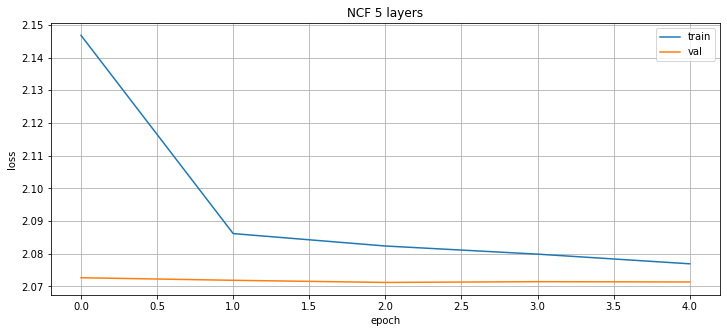

In [140]:
plot_losses(train_losses, val_losses, title="NCF 5 layers")

##### Вывод:
Можем наблюдать,что при проводимых экспериментах для совсем небольшого числа эпох(5) выбранная для сети с большим числом слоёв особая функция активации помогла добиться такого же результата по качеству на валидационной выборке в смысле RMSE как для сети с меньшим числом слоёв. 

Следовательно вполне естественнно сделать заключение, что при увеличении числа эпох качество для сети с большим числом слоёв превзойдёт качество сети с меньшим числом слоёв.

Также отметим, что лосс на обучающей выборке для модели с большим числом слоёв оказался больше, чем для модели с меньшим числом слоёв, что тоже неудивительно, так как для обучения более сложной модели нужно большее количество эпох

### Как можно улучшать архитектуру?

Чтобы улучшить качество, добавим в модель сторонних признаков

#### Добавление признаков

`transactions.csv` — список всех транзакций за определённый период времени

In [48]:
transactions = pd.read_csv('transactions.csv',
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'consumption_mode': 'category',
        'ts': np.float64,
        'watched_time': np.uint64,
        'device_type': np.uint8,
        'device_manufacturer': np.uint8
    }
)

In [49]:
transactions.rename(columns = {'user_uid':'user_id', 'element_uid':'item_id'}, inplace = True)

 - `item_id` — идентификатор элемента
 - `user_id` — идентификатор пользователя
 - `consumption_mode` — тип потребления (`P` — покупка, `R` — аренда, `S` — просмотр по подписке)
 - `ts` — время совершения транзакции или начала просмотра в случае просмотра по подписке
 - `watched_time` — число просмотренных по транзакции секунд
 - `device_type` — анонимизированный тип устройства, с которого была совершена транзакция или начат просмотр
 - `device_manufacturer` — анонимизированный производитель устройства, с которого была совершена транзакция или начат просмотр

In [50]:
transactions['user_id'] = u_enc.fit_transform(transactions['user_id'])
transactions['item_id'] = i_enc.fit_transform(transactions['item_id'])

In [51]:
transactions.sort_values('ts', inplace = True)
transactions.reset_index(drop=True, inplace = True)

In [74]:
transactions.head()

,item_id,user_id,consumption_mode,ts,watched_time,device_type,device_manufacturer
0,5021,238768,S,4.173063e+07,19586,0,11
1,4946,49740,S,4.173063e+07,6831,0,50
2,7221,42432,S,4.173063e+07,5763,0,11
3,6847,386167,S,4.173063e+07,8360,0,50
4,1807,152191,S,4.173063e+07,2503,0,11


In [120]:
dataframe.set_index('user_id', inplace = True)

In [121]:
devices_number = transactions.groupby('user_id')['device_type'].nunique()
devices_number = devices_number.rename('devices_number')
dataframe = dataframe.join(devices_number)

In [125]:
mean_watched_time = transactions.groupby('user_id')['watched_time'].mean() 
mean_watched_time = mean_watched_time.rename('mean_watched_time')
dataframe = dataframe.join(mean_watched_time)

In [134]:
number_of_actions = transactions.groupby('user_id')['consumption_mode'].count()
number_of_actions = number_of_actions.rename('number_of_actions')
dataframe = dataframe.join(number_of_actions)

In [138]:
dataframe.sort_values('ts', inplace = True)

In [140]:
dataframe.reset_index(inplace = True)

### Построение модели

In [242]:
class RatingsDatasetWithFeatures(Dataset):
    
    def __init__(self, X, y=None):

        self.users = X.user_id
        self.items = X.item_id
        self.ratings = y
        # добавили признаки
        self.another_features = X.drop(columns = ['user_id','item_id']).values
        
    def __len__(self,):

        return len(self.users)

    def __getitem__(self, i):
        
        return self.users[i], self.items[i], self.ratings[i], self.another_features[i]
    
    @staticmethod
    def collate(batch):

        users = torch.tensor([elem[0] for elem in batch])
        items = torch.tensor([elem[1] for elem in batch])
        ratings = torch.tensor([elem[2] for elem in batch])    
        another_features = torch.tensor([elem[3] for elem in batch])
        
        return users, items, ratings, another_features

In [226]:
class NeuralCF_modern(nn.Module):
    def __init__(self, n_extra_features, n_users, n_items, n_factors,  hidden_layers_sizes, activations, dropouts, minmax):
        super().__init__()
        
        self.n_extra_features = n_extra_features
        self.n_factors = n_factors
        self.n_users = n_users
        self.n_items = n_items
        self.min_rating, self.max_rating = minmax
        
        self.u_emb = nn.Embedding(self.n_users, self.n_factors)
        self.i_emb = nn.Embedding(self.n_items, self.n_factors)
    
        # реализуем первый блок, входная признаковая размерность равна n_factors*2 + n_extra_features,
        # так как мы сначала конкатенируем полученные эмбеддинги для юзеров и айтемом и дополнительные признаки
        layers = [Block(2*n_factors + n_extra_features, hidden_layers_sizes[0], activation = activations[0], dropout = dropouts[0])]
        
        for i in range(len(hidden_layers_sizes)-1):
            layers.append(Block(hidden_layers_sizes[i], hidden_layers_sizes[i+1], activation = activations[i+1], dropout = dropouts[i+1]))
            
        layers.append(nn.Linear(hidden_layers_sizes[-1], 1))
        
        
        layers.append(nn.Sigmoid())
        
        self.net = nn.Sequential(*layers)
                

    def forward(self, users, items, another_features): 
        
        # получим признаки с помощью генерации эмбеддингов для юзеров и айтемов
        features = torch.cat([self.u_emb(users), self.i_emb(items), another_features.float()], dim=1)
        out = self.net(features)
        
        #преобразуем полученные рейтинги из [0,1] в [min_rating, max_rating]
        
        return (self.max_rating - self.min_rating) * out + self.min_rating     

In [227]:
def run_epoch_modern(stage, model, dataloader, loss_fn, optimizer, epoch, device):
    
    if stage == "train":
        model.train()
        torch.set_grad_enabled(True)
    else:
        torch.set_grad_enabled(False)
        model.eval()

    model = model.to(device)
    
    losses = []
    for batch in tqdm(dataloader, total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}"):
        us, its, ys_true, feats = batch
                
        ys_pred = model(us.to(device), its.to(device), feats.to(device))
        loss = loss_fn(ys_pred, ys_true.to(device))

        if stage == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
                
        losses.append(loss.detach().cpu().item())

    return np.mean(losses)

In [228]:
def run_experiment_modern(model, dataloader_train, dataloader_val, loss_fn, optimizer, num_epochs, device, output_dir):
    
    train_losses = []
    val_losses = []

    best_val_loss = np.inf
    best_val_loss_epoch = -1
    best_val_loss_fn = None

    for epoch in range(num_epochs):
        train_loss = run_epoch_modern("train", model, dataloader_train, loss_fn, optimizer, epoch, device)
        train_losses.append(train_loss)

        val_loss = run_epoch_modern("val", model, dataloader_val, loss_fn, optimizer, epoch, device)
        val_losses.append(val_loss)

        print(f"epoch: {str(epoch).zfill(3)} | train_loss: {train_loss:5.3f}, val_loss: {val_loss:5.3f} (best: {best_val_loss:5.3f})")

        if val_loss < best_val_loss:

            best_val_loss = val_loss
            best_val_loss_epoch = epoch

            output_fn = os.path.join(output_dir, f"epoch={str(epoch).zfill(2)}_valloss={best_val_loss:.3f}.pth.tar")
            save_checkpoint(model, output_fn)
            print(f"New checkpoint saved to {output_fn}")

            best_val_loss_fn = output_fn

        print()

    print (f"Best val_loss = {best_val_loss:.3f} reached at epoch {best_val_loss_epoch}")
    load_checkpoint(model, best_val_loss_fn)

    return train_losses, val_losses, best_val_loss, model

### Как ещё можно улучшать архитектуру?

Можно использовать гибридные модели. Разные нейронные сети строить для разных входов(юзеров,айтемов и признаков), а потом мёрджить результаты. Можно решать задачу не как задачу регрессии, а как задачу ранжирования и подстраивать модель под nDCG или классификации, в этом случае поменяется выходной слой сети. Чтобы учитывать факт, что нам гораздо важнее меньше ошибаться для хороших оценок фильмов, чтобы можно было их как раз и рекомендовать, можно сделать что-то вроде взвешенного RMSE